# Hydraulic Model

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import json

from SALib.sample.sobol import sample
from SALib.analyze import sobol

### Inputs
For varying soil matric potentials hb and transpiration rates E we calculate the leaf water potential hleaf

#### Inputs

In [3]:
h_b = -1*np.arange(10,15010+100,100, dtype=int) #bulk soil water potential in cm heads
E = 3e-6*np.arange(0,3000+1,1) #transpiration rate in cm3 s**-1

In [4]:
#R_root = 0.08e7 # hPa cm**-3 s; for the blue 0.08; for the green 0.12; inverse of conductance
r0 = 0.05 # cm root radius in cm
#r2 = 5. # bulk+root+rhizo soil radius in cm
V_root = np.pi*3000
#L = 30000. # root length in cm - for the blue 1000 - for the green 10000

In [5]:
soil_types_interested = ["Clay", "Silt Loam", "Sandy Loam"] # soil types we're interested in

In [6]:
h_leaf_reg, h_b_reg = np.meshgrid(np.arange(-30000, 0+100, 100), h_b) # Regular grid

hb_reg_uni = np.flipud(np.unique(h_b_reg)) # all h_b values plotted in the E(h_leaf, h_b) surface
hleaf_reg_uni = np.unique(h_leaf_reg) # all h_leaf values plotted in the E(h_leaf, h_b) surface

#### Sensitivity Analysis

define problem for soil comparison

In [7]:
variables = ['Root Resistance', 'h_0,x', 'tau xylem', 'Root Length']
variables_legend = [r'$\mathbf{R_{\text{root}}}$', r'$\mathbf{h_{0,x}}$', r'$\mathbf{\tau_x}$', r'$\mathbf{L_{\text{root}}}$']
num_vars = len(variables)

problem = {
    'num_vars': num_vars,
    'names': variables,
    'bounds': [[0.03e7, 0.15e7],
               [-27000, -15000],
               [3, 9],
               [3000, 300000]
               ]
}

Generate Sample

In [8]:
N_fact = 10
N_skip = 15

param_values = sample(problem, 2**N_fact, skip_values=2**N_skip) # generate sample

Run Model

In [9]:
#SOL_sobol = np.array([HydraulicModel(E, h_b, params) for params in tqdm(param_values)])

Load SOL

In [10]:
SOL_sobol_dict = {}

for soil in soil_types_interested:
    print(soil)
    with open('../2_Data/SA/SA Euler 02/SOL_SA_{}.json'.format(soil)) as f:
        SOL_sobol_json = json.load(f)

        SOL_sobol = np.empty((np.shape(SOL_sobol_json)))

        for i, SOL in enumerate(SOL_sobol_json):
            SOL_sobol[i] = np.array(SOL) # transform the transpiration values in array
        
        # Add to dictionary for easier handling later
        SOL_sobol_dict[soil] = {
            'SOL sobol': SOL_sobol
        }

Clay
Silt Loam
Sandy Loam


Check out SOL

In [11]:
soil = 'Silt Loam'

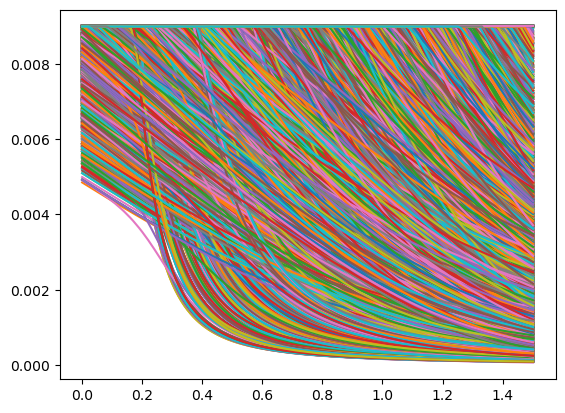

In [12]:
for i, SOL in enumerate(SOL_sobol_dict[soil]['SOL sobol']):
    plt.plot(-SOL[:,0] * 1e-4, SOL[:,2], label=i)

#plt.legend()
plt.show()

SA from leaf perspective

In [13]:
# Calculate the point density along the curve

def norm(vect):
    min = np.min(vect)
    max = np.max(vect)

    if (max - min) == 0:
        return vect

    else:
        return (vect - min) / (max - min) # normalize to [0, 1] interval

def curve_density(x, y): # x and y are the point coordinates of the curve

    # normalize
    x_norm = norm(x)
    y_norm = norm(y)

    # compute the differenve between each point along the x axis and along the y axis
    diff_x = np.diff(x_norm)
    diff_y = np.diff(y_norm)
    diff_curve = np.sqrt(diff_x**2 + diff_y**2) # difference between the points of the curve

    return 1/diff_curve

In [14]:
# Bin along x axis

def bin_leaf(curve, x_axis_bin):
    x = curve[:, 1] # x axis is leaf vector
    y = curve[:, 2] # y axis is transpiration vector

    dens = curve_density(x, y) # calculate the point density along the curve
    weights = np.append(dens, dens[-1]) # append the last elements of the weights to the array (dens vector has only lenght 150)

    curve_weighted = y * weights # weight each hleaf value with the point density

    df = pd.DataFrame({
        'X': x,
        'Y': curve_weighted,
    })

    df['Xbins'] = np.digitize(x, x_axis_bin) # split the x axis into bins
    df['Ygroup'] = df.groupby('Xbins').Y.transform('mean') # transform the wighted elements >> either sum, mean, min

    return df['Ygroup']

In [15]:
# Add the leaf perspective to the dictionary

red_val = 0 # value that reduces the number of points along the x axis to make bins larger
hleaf_bin = np.linspace(-10, -30000, len(hb_reg_uni))
hleaf_bin_red = np.linspace(-10, -30000, len(hb_reg_uni)-red_val)

for soil in soil_types_interested:
    Leaf_binned = []
    
    for i, SOL in enumerate(SOL_sobol_dict[soil]['SOL sobol']):
        SOL_leaf = bin_leaf(SOL, hleaf_bin_red)
        Leaf_binned.append(SOL_leaf)
        
    SOL_sobol_dict[soil]['Leaf binned'] = np.array(Leaf_binned)

Compute the SA indices

In [16]:
for soil in soil_types_interested:
    SOL_leaf_bin = np.array(SOL_sobol_dict[soil]['Leaf binned'])
    SOL_soil = np.array(SOL_sobol_dict[soil]['SOL sobol'][:,:,2])
    SOL_leaf = np.array(SOL_sobol_dict[soil]['SOL sobol'][:,:,1])

    ST_leaf_bin = np.zeros((len(SOL_leaf_bin.T), num_vars))  # Total-order indices (ST)
    ST_leaf_bin_conf = np.zeros((len(SOL_leaf_bin.T), num_vars))  # confidence interval of ST
    ST_soil = np.zeros((len(SOL_soil.T), num_vars))  # Total-order indices (ST)
    ST_soil_conf = np.zeros((len(SOL_soil.T), num_vars))  # confidence interval of ST
    ST_leaf = np.zeros((len(SOL_leaf.T), num_vars))  # Total-order indices (ST)
    ST_leaf_conf = np.zeros((len(SOL_leaf.T), num_vars))  # confidence interval of ST

    # Compute Sobol indices for each output index (WP step)
    for i in range(len(SOL_leaf.T)):
        Si_leaf_bin = sobol.analyze(problem, SOL_leaf_bin[:, i], print_to_console=False)
        ST_leaf_bin[i, :] = Si_leaf_bin['ST']  # Store Total-effect indices
        ST_leaf_bin_conf[i, :] = Si_leaf_bin['ST_conf']

        Si_soil = sobol.analyze(problem, SOL_soil[:, i], print_to_console=False)
        ST_soil[i, :] = Si_soil['ST']  # Store Total-effect indices
        ST_soil_conf[i, :] = Si_soil['ST_conf']

        Si_leaf = sobol.analyze(problem, SOL_leaf[:, i], print_to_console=False)
        ST_leaf[i, :] = Si_leaf['ST']  # Store Total-effect indices
        ST_leaf_conf[i, :] = Si_leaf['ST_conf']

    # Store indices in dictionary
    SOL_sobol_dict[soil]['ST_leaf_bin'] = ST_leaf_bin
    SOL_sobol_dict[soil]['ST_leaf_bin_conf'] = ST_leaf_bin_conf

    SOL_sobol_dict[soil]['ST_soil'] = ST_soil
    SOL_sobol_dict[soil]['ST_soil_conf'] = ST_soil_conf

    SOL_sobol_dict[soil]['ST_leaf'] = ST_leaf
    SOL_sobol_dict[soil]['ST_leaf_conf'] = ST_leaf_conf

/Users/alien/opt/miniconda3/envs/soil/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


### Testing

Plot different perspectives

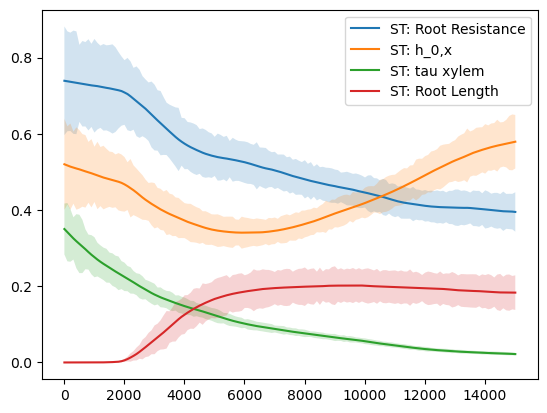

In [17]:
# Soil for testing
soil = 'Clay'

for i in range(num_vars):
    plt.plot(-hb_reg_uni, SOL_sobol_dict[soil]['ST_soil'][:, i], label='ST: {}'.format(problem['names'][i]))
    plt.fill_between(-hb_reg_uni, SOL_sobol_dict[soil]['ST_soil'][:, i] - SOL_sobol_dict[soil]['ST_soil_conf'][:, i], SOL_sobol_dict[soil]['ST_soil'][:, i] + SOL_sobol_dict[soil]['ST_soil_conf'][:, i], alpha=0.2)

plt.legend()

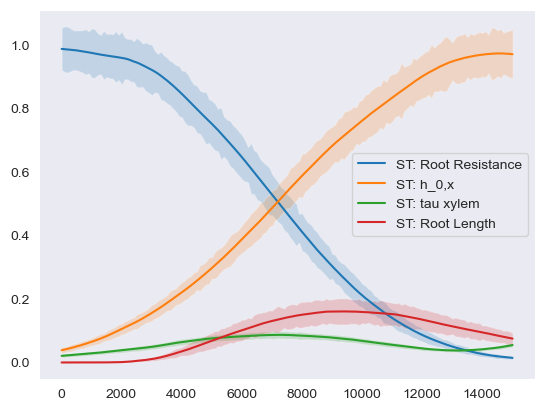

In [34]:
# Leaf for testing
soil = 'Silt Loam'

for i in range(num_vars):
    plt.plot(-hb_reg_uni, SOL_sobol_dict[soil]['ST_leaf'][:, i], label='ST: {}'.format(problem['names'][i]))
    plt.fill_between(-hb_reg_uni, SOL_sobol_dict[soil]['ST_leaf'][:, i] - SOL_sobol_dict[soil]['ST_leaf_conf'][:, i], SOL_sobol_dict[soil]['ST_leaf'][:, i] + SOL_sobol_dict[soil]['ST_leaf_conf'][:, i], alpha=0.2)

plt.legend()

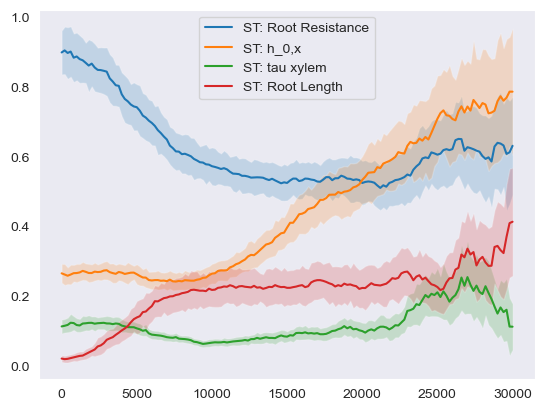

In [36]:
# Leaf bin for testing
soil = 'Clay'

for i in range(num_vars):
    plt.plot(-hleaf_bin, SOL_sobol_dict[soil]['ST_leaf_bin'][:, i], label='ST: {}'.format(problem['names'][i]))
    plt.fill_between(-hleaf_bin, SOL_sobol_dict[soil]['ST_leaf_bin'][:, i] - SOL_sobol_dict[soil]['ST_leaf_bin_conf'][:, i], SOL_sobol_dict[soil]['ST_leaf_bin'][:, i] + SOL_sobol_dict[soil]['ST_leaf_bin_conf'][:, i], alpha=0.2)

plt.legend()

In [37]:
for soil in soil_types_interested:
    data = []

    ST_leaf = SOL_sobol_dict[soil]['ST_leaf_bin']
    ST_soil = SOL_sobol_dict[soil]['ST_soil']

    for i, var in enumerate(variables):
        for j in range(len(ST_leaf)):
            data.append({
                'Soil': ST_soil[j, i],
                'Leaf': ST_leaf[j, i],
                'Parameter': var
            })
        
            if var == 'tau xylem':
                data.remove({
                    'Soil': ST_soil[j, i],
                    'Leaf': ST_leaf[j, i],
                    'Parameter': var
                })

    df_SA = pd.DataFrame(data)
    
    SOL_sobol_dict[soil]['df_joint'] = df_SA

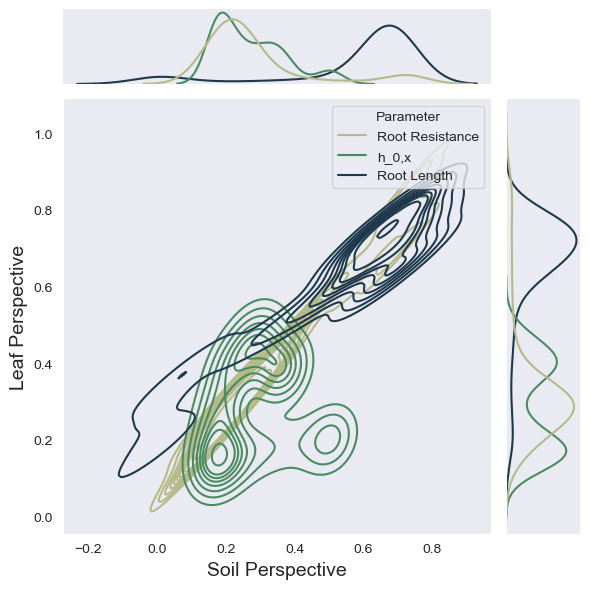

In [40]:
# Plot
soil ='Sandy Loam'
df_SA = SOL_sobol_dict[soil]['df_joint']

sns.set_style('dark')

fontsize=14

cmap = sns.cubehelix_palette(start=0.1, rot=-.75, light=0.7, dark=0.2, n_colors=3)

g = sns.jointplot(
    data=df_SA,
    x="Soil",
    y="Leaf",
    hue="Parameter",
    kind="kde",
    palette=cmap,
)

g.set_axis_labels('Soil Perspective', 'Leaf Perspective', fontsize=fontsize)

plt.tight_layout()
plt.show()

['Root Resistance', 'h_0,x', 'tau xylem', 'Root Length']


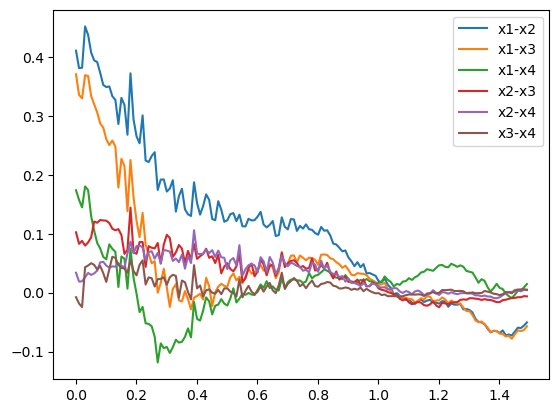

In [43]:
plt.plot(-hb_reg_uni * 1e-4, S2_array[:,0][:,1], label='x1-x2')
plt.plot(-hb_reg_uni * 1e-4, S2_array[:,0][:,2], label='x1-x3')
plt.plot(-hb_reg_uni * 1e-4, S2_array[:,0][:,3], label='x1-x4')
plt.plot(-hb_reg_uni * 1e-4, S2_array[:,1][:,2], label='x2-x3')
plt.plot(-hb_reg_uni * 1e-4, S2_array[:,1][:,3], label='x2-x4')
plt.plot(-hb_reg_uni * 1e-4, S2_array[:,2][:,3], label='x3-x4')

#plt.fill_between(-hb_reg_uni * 1e-4, S2_array[:,0][:,1]-S2_conf_array[:,0][:,1], S2_array[:,0][:,1]+S2_conf_array[:,0][:,1], alpha=0.2)
#plt.fill_between(-hb_reg_uni * 1e-4, S2_array[:,0][:,2]-S2_conf_array[:,0][:,2], S2_array[:,0][:,2]+S2_conf_array[:,0][:,2], alpha=0.2)
#plt.fill_between(-hb_reg_uni * 1e-4, S2_array[:,1][:,2]-S2_conf_array[:,1][:,2], S2_array[:,1][:,2]+S2_conf_array[:,1][:,2], alpha=0.2)

plt.legend()

print(variables)

['Root Resistance', 'h_0,x', 'tau xylem', 'Root Length']


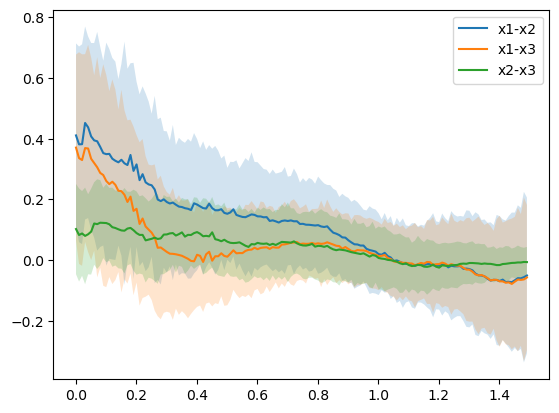

In [222]:
soil = 'Clay'

plt.plot(-hb_reg_uni * 1e-4, SOL_sobol_dict[soil]['S2'][:,0][:,1], label='x1-x2')
plt.plot(-hb_reg_uni * 1e-4, SOL_sobol_dict[soil]['S2'][:,0][:,2], label='x1-x3')
plt.plot(-hb_reg_uni * 1e-4, SOL_sobol_dict[soil]['S2'][:,1][:,2], label='x2-x3')

plt.fill_between(-hb_reg_uni * 1e-4, SOL_sobol_dict[soil]['S2'][:,0][:,1]-SOL_sobol_dict[soil]['S2_conf'][:,0][:,1], SOL_sobol_dict[soil]['S2'][:,0][:,1]+SOL_sobol_dict[soil]['S2_conf'][:,0][:,1], alpha=0.2)
plt.fill_between(-hb_reg_uni * 1e-4, SOL_sobol_dict[soil]['S2'][:,0][:,2]-SOL_sobol_dict[soil]['S2_conf'][:,0][:,2], SOL_sobol_dict[soil]['S2'][:,0][:,2]+SOL_sobol_dict[soil]['S2_conf'][:,0][:,2], alpha=0.2)
plt.fill_between(-hb_reg_uni * 1e-4, SOL_sobol_dict[soil]['S2'][:,1][:,2]-SOL_sobol_dict[soil]['S2_conf'][:,1][:,2], SOL_sobol_dict[soil]['S2'][:,1][:,2]+SOL_sobol_dict[soil]['S2_conf'][:,1][:,2], alpha=0.2)

plt.legend()

print(variables)

### Plotting

Plot Sensitivity indices

In [23]:
"""
# prepare colormap
cmap_name = 'ocean'
cmap = get_cmap(cmap_name)

labels = ['a)', 'b)']

# Plot sensitivity indices for SOL
plt.figure(1)
plt.subplots_adjust(hspace=3)
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

for i in range(num_vars):
    color = cmap(i / num_vars)

    # First order sensitivity
    ax1 = axs[0]
    ax1.plot(-hb_reg_uni * 1e-4, S1_array_smooth[:, i], color=color, label='S1: {}'.format(problem['names'][i]))
    ax1.fill_between(-hb_reg_uni * 1e-4, S1_array_smooth[:, i]-S1_conf_array_smooth[:, i], S1_array_smooth[:, i]+S1_conf_array_smooth[:, i], alpha=0.2, color=color)
    #ax1.legend()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylabel('First Order Sensitivity Index')

    ax1.text(0.05, 1.06, labels[0], transform=ax1.transAxes, fontsize=12, va='top', ha='right') # add a)

    # Total sensitivity
    ax2 = axs[1]
    ax2.plot(-hb_reg_uni * 1e-4, ST_array_Ssmooth[:, i], color=color, label=problem['names'][i])
    ax2.fill_between(-hb_reg_uni * 1e-4, ST_array_smooth[:, i]-ST_conf_array_smooth[:, i], ST_array_smooth[:, i]+ST_conf_array_smooth[:, i], alpha=0.2, color=color)
    #ax2.legend()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylabel('Total Sensitivity Index')
    ax2.set_xlabel(r'$-\psi_{soil} \ [MPa]$')
    ax2.tick_params(bottom=True)
    #ax2.legend(bbox_to_anchor=(0.0, 1.1, 1., .01), loc='center left', ncols=3, mode="expand")
    ax2.legend(bbox_to_anchor=(-0.05, 1.1, 1., .01), loc='center right')

    ax2.text(0.05, 1.06, labels[1], transform=ax2.transAxes, fontsize=12, va='top', ha='right') # add b)

#plt.title('Sensitivity Analysis of SOL for {}'.format(soil))
plt.savefig('SA_{}.png'.format(soil), dpi=300)
#plt.tight_layout()
plt.show()

"""

'\n# prepare colormap\ncmap_name = \'ocean\'\ncmap = get_cmap(cmap_name)\n\nlabels = [\'a)\', \'b)\']\n\n# Plot sensitivity indices for SOL\nplt.figure(1)\nplt.subplots_adjust(hspace=3)\nfig, axs = plt.subplots(2, 1, figsize=(10, 7))\n\nfor i in range(num_vars):\n    color = cmap(i / num_vars)\n\n    # First order sensitivity\n    ax1 = axs[0]\n    ax1.plot(-hb_reg_uni * 1e-4, S1_array_smooth[:, i], color=color, label=\'S1: {}\'.format(problem[\'names\'][i]))\n    ax1.fill_between(-hb_reg_uni * 1e-4, S1_array_smooth[:, i]-S1_conf_array_smooth[:, i], S1_array_smooth[:, i]+S1_conf_array_smooth[:, i], alpha=0.2, color=color)\n    #ax1.legend()\n    ax1.spines[\'top\'].set_visible(False)\n    ax1.spines[\'right\'].set_visible(False)\n    ax1.spines[\'bottom\'].set_visible(False)\n    ax1.set_xticks([])\n    ax1.set_ylabel(\'First Order Sensitivity Index\')\n\n    ax1.text(0.05, 1.06, labels[0], transform=ax1.transAxes, fontsize=12, va=\'top\', ha=\'right\') # add a)\n\n    # Total sensitiv

Compare Sensitivity Indices for Clay and Silt Loam

<Figure size 640x480 with 0 Axes>

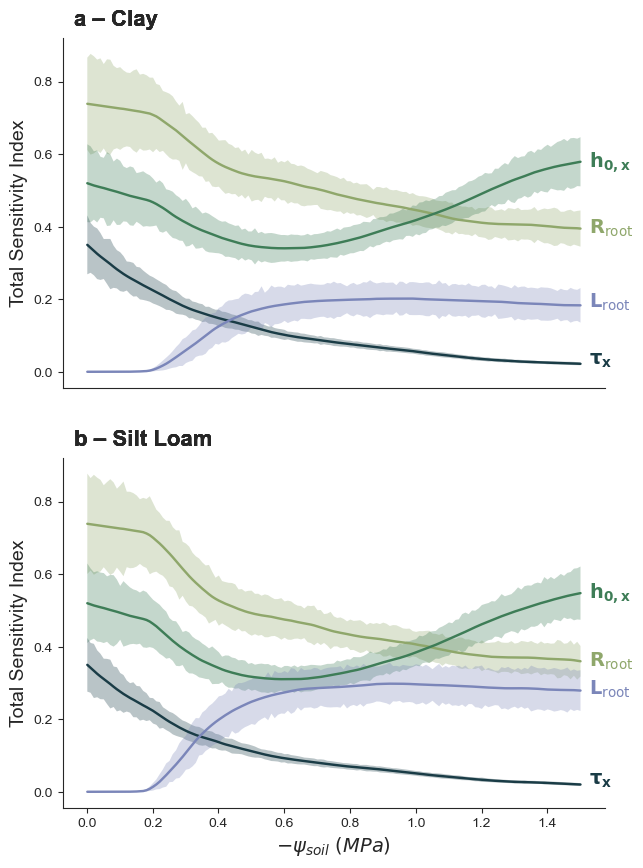

In [ ]:
# style choices
sns.set_style('white')

sffont = {'fontfamily': 'sans serif'}
fontsize=14

# prepare colormap
#cmap = ["#6A972D", "#95a4e6", "#3F2D76", '#346f4e']

cmap = sns.cubehelix_palette(start=0., rot=-.75, light=0.8, dark=0.2, n_colors=4)
cmap = cmap[1:]

cmap_contrast = sns.cubehelix_palette(start=0.5, rot=1.5, light=.75, dark=0.1, n_colors=4) # colormap
idx_L = variables.index('Root Length') # find where the Root Length is for contrast colour
cmap.insert(idx_L, cmap_contrast[1])

labels = ['a', 'b', 'c']
alpha = 0.3

# Plot sensitivity indices for SOL
plt.figure(1)
plt.subplots_adjust(hspace=3)
fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharey=True, sharex=True)

range_vars = iter(range(num_vars))

for i in range_vars:
    color = cmap[i]

    for j, soil in enumerate(soil_types_interested[0:2]):
        ST_array = SOL_sobol_dict[soil]['ST_soil']
        ST_array_conf = SOL_sobol_dict[soil]['ST_soil_conf']

        ax = axs[j]
        line, = ax.plot(-hb_reg_uni * 1e-4, ST_array[:, i], color=color, label=variables_legend[i], linewidth=1.75)
        ax.fill_between(-hb_reg_uni * 1e-4, ST_array[:, i]-ST_array_conf[:, i], ST_array[:, i]+ST_array_conf[:, i], alpha=alpha, color=color, edgecolor='none')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)

        #ax.set_xlabel(r'$-\psi_{soil} \ [MPa]$', fontsize=fontsize)

        ax.text(0.02, 1.08, labels[j]+' – '+soil, transform=ax.transAxes, va='top', ha='left', fontsize=fontsize+2, weight='bold') # add label

        #ax.tick_params(bottom=True)

        ax.set_ylabel('Total Sensitivity Index', fontsize=fontsize)
        ax.tick_params(left=True)

        ## Legend
        # Get the x and y data
        x_data = line.get_xdata()
        y_data = line.get_ydata()

        # Last point – to place the legend
        last_point = [x_data[-1], y_data[-1]]

        t = plt.text(0.97, last_point[1]+0.03, variables_legend[i], fontsize=fontsize, color=color, weight='bold', va='bottom', ha='left', transform=ax.transAxes)

        if j == 1:
            ax.set_xlabel(r'$-\psi_{soil} \ (MPa)$', fontsize=fontsize)
            ax.tick_params(bottom=True)


# legend
#ax = axs[-1]
#handles, labels = ax.get_legend_handles_labels()
#order = [0, 3, 1, 2] # specify order

#leg = ax.legend([handles[k] for k in order], [labels[k] for k in order], bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False, fontsize=fontsize)
#for line in leg.get_lines():
#    line.set_linewidth(3.0) # make lines in legend thicker

#plt.title('Sensitivity Analysis of SOL for {}'.format(soil))
#plt.tight_layout()
plt.savefig('SA_ST_ab.png', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'S1_soil'

<Figure size 640x480 with 0 Axes>

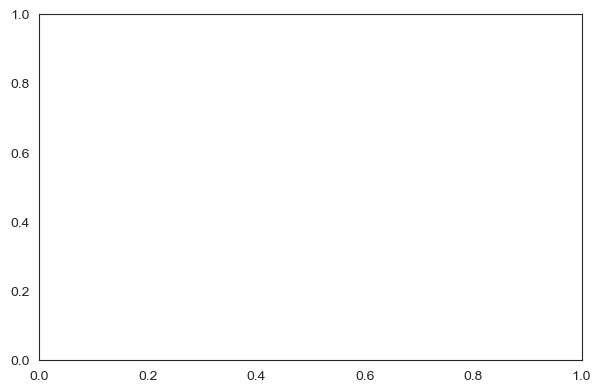

In [ ]:
# style choices
sns.set_style('white')

sffont = {'fontfamily': 'sans serif'}
fontsize=14

# prepare colormap
#cmap = ["#6A972D", "#95a4e6", "#3F2D76", '#346f4e']

cmap = sns.cubehelix_palette(start=0., rot=-.75, light=0.8, dark=0.2, n_colors=4)
cmap = cmap[1:]

cmap_contrast = sns.cubehelix_palette(start=0.5, rot=1.5, light=.75, dark=0.1, n_colors=4) # colormap
idx_L = variables.index('Root Length') # find where the Root Length is for contrast colour
cmap.insert(idx_L, cmap_contrast[1])

labels = ['a', 'b', 'c']
alpha = 0.3

# Plot sensitivity indices for SOL
plt.figure(1)
plt.subplots_adjust(hspace=3)
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5), sharey=True, sharex=True)

range_vars = iter(range(num_vars))

for i in range_vars:
    color = cmap[i]

    soil = 'Sandy Loam'
    ST_array = SOL_sobol_dict[soil]['ST_soil']
    ST_array_conf = SOL_sobol_dict[soil]['ST_soil_conf']

    line, = ax.plot(-hb_reg_uni * 1e-4, ST_array[:, i], color=color, label=variables_legend[i])
    ax.fill_between(-hb_reg_uni * 1e-4, ST_array[:, i]-ST_array_conf[:, i], ST_array[:, i]+ST_array_conf[:, i], alpha=alpha, color=color, edgecolor='none')

    ## Legend
    # Get the x and y data
    x_data = line.get_xdata()
    y_data = line.get_ydata()

    # Last point – to place the legend
    last_point = [x_data[-1], y_data[-1]]

    t = plt.text(0.97, last_point[1]+0.03, variables_legend[i], fontsize=fontsize, color=color, weight='bold', va='bottom', ha='left', transform=ax.transAxes)

    if j == 1:
        ax.set_xlabel(r'$-\psi_{soil} \ (MPa)$', fontsize=fontsize)
        ax.tick_params(bottom=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

#ax.set_xlabel(r'$-\psi_{soil} \ [MPa]$', fontsize=fontsize)

ax.text(0.05, 1.08, soil, transform=ax.transAxes, va='top', ha='left', fontsize=fontsize+2, weight='bold') # add label

ax.tick_params(bottom=True)

ax.set_ylabel('Total Sensitivity Index', fontsize=fontsize)
ax.tick_params(left=True)

ax.set_xlabel(r'$-\psi_{soil} \ (MPa)$', fontsize=fontsize)

# legend
#handles, labels = ax.get_legend_handles_labels()
#order = [0, 3, 1, 2] # specify order

#leg = ax.legend([handles[k] for k in order], [labels[k] for k in order], bbox_to_anchor=(1.02, 0.5), loc='center left', frameon=False, fontsize=fontsize)
#for line in leg.get_lines():
#    line.set_linewidth(3.0) # make lines in legend thicker

#plt.title('Sensitivity Analysis of SOL for {}'.format(soil))
#plt.tight_layout()
plt.savefig('SA_ST_c.png', dpi=300, bbox_inches='tight')
plt.show()

### Save sensitivity indices

In [107]:
sensitivity = {}

sensitivity['S1'] = S1_array
sensitivity['S1_conf'] = S1_conf_array
sensitivity['S2'] = S2_array
sensitivity['S2_conf'] = S2_conf_array
sensitivity['ST'] = ST_array
sensitivity['ST_conf'] = ST_conf_array

sensitivity = {key:value.tolist() for key, value in sensitivity.items()}

with open('Sensitivity_{}.json'.format(soil), 'w') as f:
    json.dump(sensitivity, f, indent=4)

Save SOL

In [32]:
SOL_json = {'SOL sobol': SOL_sobol_SandyLoam['SOL sobol'], 'SOL sobol smooth': SOL_sobol_SandyLoam_smoothed.tolist()}

with open('SOL_SA_{}.json'.format('SandyLoam'), 'w') as f:
    json.dump(SOL_json, f, indent=4)

Save the indices

In [23]:
SA_indices_json = {'Clay': {'S1': S1_array_Clay_smooth.tolist(),
                            'S1 conf': S1_conf_array_Clay_smooth.tolist(),
                            'ST': ST_array_Clay_smooth.tolist(),
                            'ST conf': ST_conf_array_Clay_smooth.tolist()},
                'SiltLoam': {'S1': S1_array_SiltLoam_smooth.tolist(),
                            'S1 conf': S1_conf_array_SiltLoam_smooth.tolist(),
                            'ST': ST_array_SiltLoam_smooth.tolist(),
                            'ST conf': ST_conf_array_SiltLoam_smooth.tolist()},
                'SandyLoam': {'S1': S1_array_SandyLoam_smooth.tolist(),
                            'S1 conf': S1_conf_array_SandyLoam_smooth.tolist(),
                            'ST': ST_array_SandyLoam_smooth.tolist(),
                            'ST conf': ST_conf_array_SandyLoam_smooth.tolist()}
                }

with open('SA_indices.json', 'w') as f:
    json.dump(SA_indices_json, f, indent=4)

In [182]:
SOL_sobol_json = {soil: {param: values.tolist() for param, values in params.items()} 
                  for soil, params in SOL_sobol_dict.items()}

with open('SA_indices.json', 'w') as f:
    json.dump(SOL_sobol_json, f, indent=4, allow_nan=True)